sos_ecor_wind_comparison - add wind speed, change sublimation rate back to latent heat flux, M-O approaches to latent heat flux, find downvalley and up valley potential temps (Schofield pass SNOTEL) and note elevation of each

In [1]:
import os
import act
import glob
import xarray as xr

import sys
sys.path.append('../')
import sosutils
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import altair as alt
import ftplib
import pytz
import datetime

# User Inputs

## SOS

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# datelist = ['20221031', '20221101', '20221102']
datelist = ['20221215', '20221216', '20221217', '20221218', '20221219']
start_date = datelist[0]
end_date = datelist[-1]


VARIABLE_NAMES = [ 
    'spd_1m_c', 'dir_1m_c', 'u_1m_c', 'v_1m_c', 'u_w__1m_c', 'u_tc__1m_c', 'v_w__1m_c', 'v_tc__1m_c', 'w_tc__1m_c', 'w_h2o__1m_c',
    'spd_2m_c', 'dir_2m_c', 'u_2m_c', 'v_2m_c', 'u_w__2m_c', 'u_tc__2m_c', 'v_w__2m_c', 'v_tc__2m_c', 'w_tc__2m_c', 'w_h2o__2m_c',
    'spd_3m_c', 'dir_3m_c', 'u_3m_c', 'v_3m_c', 'u_w__3m_c', 'u_tc__3m_c', 'v_w__3m_c', 'v_tc__3m_c', 'w_tc__3m_c', 'w_h2o__3m_c',
    'spd_5m_c', 'dir_5m_c', 'u_5m_c', 'v_5m_c', 'u_w__5m_c', 'u_tc__5m_c', 'v_w__5m_c', 'v_tc__5m_c', 'w_tc__5m_c', 'w_h2o__5m_c',
    'spd_10m_c', 'dir_10m_c', 'u_10m_c', 'v_10m_c', 'u_w__10m_c', 'u_tc__10m_c', 'v_w__10m_c', 'v_tc__10m_c', 'w_tc__10m_c', 'w_h2o__10m_c',
    'spd_15m_c', 'dir_15m_c', 'u_15m_c', 'v_15m_c', 'u_w__15m_c', 'u_tc__15m_c', 'v_w__15m_c', 'v_tc__15m_c', 'w_tc__15m_c', 'w_h2o__15m_c',
    'spd_20m_c', 'dir_20m_c', 'u_20m_c', 'v_20m_c', 'u_w__20m_c', 'u_tc__20m_c', 'v_w__20m_c', 'v_tc__20m_c', 'w_tc__20m_c', 'w_h2o__20m_c',
    
    'tc_1m_c', 'tc_2m_c', 'tc_3m_c', 'tc_5m_c', 'tc_10m_c', 'tc_15m_c', 'tc_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c',
    'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c',
    'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'P_10m_c'
]

## ECOR

In [3]:
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
met_kp = 'gucmetS3.b1'

# start_date = '2022-10-31'
# end_date = '2022-11-02'
start_date = '20221215'
end_date = '20221219'

output_dir = '/data2/elilouis/sublimationofsnow/'
ecor_gothic_path = os.path.join(output_dir, ecor_gothic)
ecor_kp_path = os.path.join(output_dir, ecor_kp)
met_gothic_path = os.path.join(output_dir, met_gothic)
met_kp_path = os.path.join(output_dir, met_kp)

In [4]:
ecor_gothic_path,ecor_kp_path,met_gothic_path,met_kp_path

('/data2/elilouis/sublimationofsnow/guc30ecorM1.b1',
 '/data2/elilouis/sublimationofsnow/guc30ecorS3.b1',
 '/data2/elilouis/sublimationofsnow/gucmetM1.b1',
 '/data2/elilouis/sublimationofsnow/gucmetS3.b1')

In [5]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Data Download

## SOS

In [6]:
datasets = [xr.open_dataset(sosutils.download_sos_data_day(date, sos_download_dir))[VARIABLE_NAMES] for date in datelist]

sos_ds = sosutils.merge_datasets_with_different_variables(datasets, dim='time')
sos_df = sos_ds.to_dataframe().reset_index()

## ECOR

In [7]:
from tempfile import TemporaryDirectory
with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ecor_gothic,    start_date,    end_date,
        output = temp_dir
    )
    ecor_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ecor_kp,    start_date,    end_date,
        output = temp_dir
    )
    ecor_kps_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    met_gothic,    start_date,    end_date,
        output = temp_dir
    )
    met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

[DOWNLOADING] guc30ecorM1.b1.20221215.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221216.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221217.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221218.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221219.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221215.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221216.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221217.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221218.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221219.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221215.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221216.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221217.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221218.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221219.000000.cdf


In [11]:
import metpy
from metpy.units import units
import pint_xarray

# Calculations

## Potential temperatures

In [12]:
met_gothic_ds['potential temperature'] = metpy.calc.potential_temperature(
    met_gothic_ds['atmos_pressure'] * units.kPa,
    met_gothic_ds['temp_mean'] * units.celsius
).pint.to(units.celsius)

sos_ds['potential temperature'] = metpy.calc.potential_temperature(
    sos_ds['P_10m_c'] * units.millibar,
    sos_ds['T_3m_c'] * units.celsius
).pint.to(units.celsius)

## Sublimation/evaporation

In [13]:
ecor_kps_ds['sublimation rate (mm/hr)'] = 3600*ecor_kps_ds['lv_e']/2.838e6
ecor_gothic_ds['sublimation rate (mm/hr)'] = 3600*ecor_gothic_ds['lv_e']/2.838e6
sos_ds['sublimation rate (mm/hr)'] = 3600*sos_ds['w_h2o__3m_c']/1e3

# Plot wind dir, pot. temps, and moisture fluxes at Gothic ad KPS sites

## Get nighttime df

In [14]:
import numpy as np
from matplotlib import dates

In [49]:
from astral import LocationInfo
from astral.sun import sun
def get_nightime_df(timezone, lat, lon, dates):
    nighttime_df = pd.DataFrame()
    loc = LocationInfo(timezone=timezone, latitude=lat, longitude=lon)
    for date in dates:
        s = sun(loc.observer, date=date, tzinfo=loc.timezone)
        nighttime_df = pd.concat([
            nighttime_df,
            pd.DataFrame({
                'datetime': [date],
                'sunset': [s['sunset']],
                'sunrise': [s['sunrise']],
            } )
        ], ignore_index=True)
    # remove timezone info
    nighttime_df['sunset'] = nighttime_df['sunset'].dt.tz_localize(None)
    nighttime_df['sunrise'] = nighttime_df['sunrise'].dt.tz_localize(None)
    # add partial first night:
    nighttime_df = pd.concat([
            pd.DataFrame({
                'datetime': [np.nan],
                'sunset': [np.nan],
                'sunrise': [np.nan],
            }),
            nighttime_df,
            pd.DataFrame({
                'datetime': [np.nan],
                'sunset': [np.nan],
                'sunrise': [np.nan],
            })
        ], ignore_index=True)
    nighttime_df['sunrise'] = nighttime_df['sunrise'].shift(-1)
    nighttime_df.loc[0, 'sunset'] = pd.Series(sun(loc.observer, date=dates[0] - datetime.timedelta(days=1), tzinfo=loc.timezone)['sunset']).dt.tz_localize(None).iloc[0]
    nighttime_df.loc[len(dates), 'sunrise'] = dates[-1] + datetime.timedelta(days=1) 
    return nighttime_df.drop(nighttime_df.tail(1).index)

In [50]:
night_df = get_nightime_df(
    'US/Mountain', 
    ecor_gothic_ds['lat'].values[0], 
    ecor_gothic_ds['lon'].values[0],
    [datetime.datetime.strptime(date_str, '%Y%m%d') for date_str in ecor_gothic_ds.attrs['_file_dates']]
)

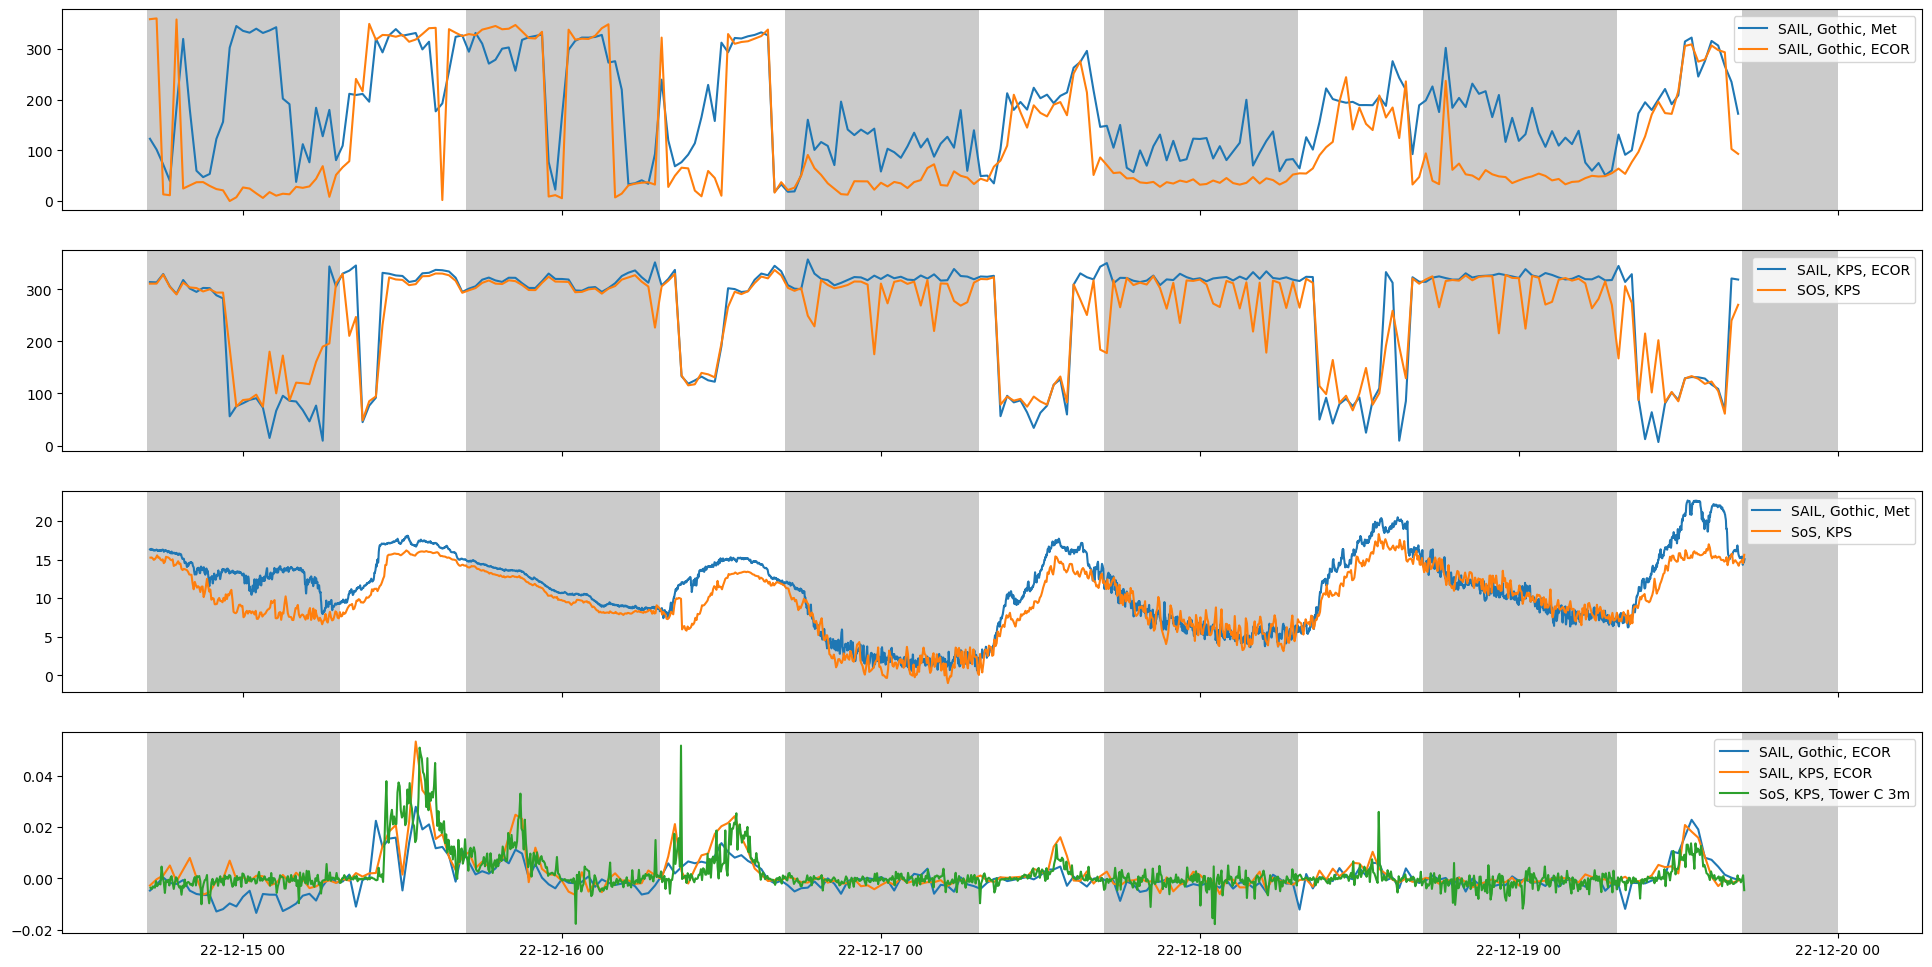

In [52]:
fig, axes = plt.subplots(4,1, figsize=(24,12), sharex=True)

met_gothic_ds_30min = met_gothic_ds.resample(time='30Min').mean()
sos_ds_30min = sos_ds.resample(time='30Min').mean()

# get local_time zones
met_gothic_ds_30min = sosutils.modify_xarray_timezone(met_gothic_ds_30min, pytz.UTC, pytz.timezone('US/Mountain'))
met_gothic_ds = sosutils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
ecor_gothic_ds = sosutils.modify_xarray_timezone(ecor_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
ecor_kps_ds = sosutils.modify_xarray_timezone(ecor_kps_ds, pytz.UTC, pytz.timezone('US/Mountain'))
sos_ds_30min = sosutils.modify_xarray_timezone(sos_ds_30min, pytz.UTC, pytz.timezone('US/Mountain'))
sos_ds = sosutils.modify_xarray_timezone(sos_ds, pytz.UTC, pytz.timezone('US/Mountain'))


# plot
axes[0].plot(met_gothic_ds_30min.local_time, met_gothic_ds_30min['wdir_vec_mean'], label='SAIL, Gothic, Met')
axes[0].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['wind_dir'], label='SAIL, Gothic, ECOR')
axes[1].plot(ecor_kps_ds.local_time, ecor_kps_ds['wind_dir'], label='SAIL, KPS, ECOR')
axes[1].plot(sos_ds_30min.local_time, sos_ds_30min['dir_3m_c'], label='SOS, KPS')
axes[2].plot(met_gothic_ds.local_time, met_gothic_ds['potential temperature'], label='SAIL, Gothic, Met')
axes[2].plot(sos_ds.local_time, sos_ds['potential temperature'], label='SoS, KPS')

axes[3].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['sublimation rate (mm/hr)'], label='SAIL, Gothic, ECOR')
axes[3].plot(ecor_kps_ds.local_time, ecor_kps_ds['sublimation rate (mm/hr)'], label='SAIL, KPS, ECOR')
axes[3].plot(sos_ds.local_time, sos_ds['sublimation rate (mm/hr)'], label='SoS, KPS, Tower C 3m')

for ax in axes:
    ax.xaxis.set_major_formatter(dates.DateFormatter('%y-%m-%d %H'))
    ax.legend()
    for i,row in night_df.iterrows():
        ax.axvspan(row['sunset'], row['sunrise'], facecolor='0.2', alpha=0.25)

# Sos data tidy and profile plots

In [26]:
sos_hourly = sos_df.loc[sos_df['time'] < "2022-11-01"].set_index('time').resample('60Min').mean().reset_index()
sos_hourly.head()

,time,spd_1m_c,dir_1m_c,u_1m_c,v_1m_c,u_w__1m_c,u_tc__1m_c,v_w__1m_c,v_tc__1m_c,w_tc__1m_c,w_h2o__1m_c,spd_2m_c,dir_2m_c,u_2m_c,v_2m_c,u_w__2m_c,u_tc__2m_c,v_w__2m_c,v_tc__2m_c,w_tc__2m_c,w_h2o__2m_c,spd_3m_c,dir_3m_c,u_3m_c,v_3m_c,u_w__3m_c,u_tc__3m_c,v_w__3m_c,v_tc__3m_c,w_tc__3m_c,w_h2o__3m_c,spd_5m_c,dir_5m_c,u_5m_c,v_5m_c,u_w__5m_c,u_tc__5m_c,v_w__5m_c,v_tc__5m_c,w_tc__5m_c,w_h2o__5m_c,spd_10m_c,dir_10m_c,u_10m_c,v_10m_c,u_w__10m_c,u_tc__10m_c,v_w__10m_c,v_tc__10m_c,w_tc__10m_c,w_h2o__10m_c,spd_15m_c,dir_15m_c,u_15m_c,v_15m_c,u_w__15m_c,u_tc__15m_c,v_w__15m_c,v_tc__15m_c,w_tc__15m_c,w_h2o__15m_c,spd_20m_c,dir_20m_c,u_20m_c,v_20m_c,u_w__20m_c,u_tc__20m_c,v_w__20m_c,v_tc__20m_c,w_tc__20m_c,w_h2o__20m_c,tc_1m_c,tc_2m_c,tc_3m_c,tc_5m_c,tc_10m_c,tc_15m_c,tc_20m_c,T_1m_c,T_2m_c,T_3m_c,T_4m_c,T_5m_c,T_6m_c,T_7m_c,T_8m_c,T_9m_c,T_10m_c,T_11m_c,T_12m_c,T_13m_c,T_14m_c,T_15m_c,T_16m_c,T_17m_c,T_18m_c,T_19m_c,T_20m_c,P_10m_c


In [27]:
sos_hourly = sos_hourly.melt(id_vars='time', value_vars=VARIABLE_NAMES)
sos_hourly['height'] = sos_hourly['variable'].apply(sosutils.height_from_variable_name)
sos_hourly['tower'] = sos_hourly['variable'].apply(sosutils.tower_from_variable_name)
sos_hourly['measurement'] = sos_hourly['variable'].apply(sosutils.measurement_from_variable_name)


In [28]:
sos_hourly.measurement.unique()

array([], dtype=object)

In [29]:
alt.Chart(sos_hourly).transform_filter(
    alt.FieldOneOfPredicate(
        'measurement', 
        ['w_tc_', 'w_h2o_', 'u_w_']
    )
).mark_line().encode(
    alt.X('value:Q', sort='-y'),
    alt.Y('height:Q'),
    alt.Color('measurement:N'),
    alt.Facet('time:T', columns=8, header=alt.Header(format="%m/%d %H:00", formatType='time'))
).properties(
    width=100, 
    height=100
)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)